### Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import scvelo as scv
import scanpy as sc
import scanpy.external as sce

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix

import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from cellbender.remove_background.downstream import anndata_from_h5
import anndata as ad

from tqdm.notebook import tqdm

In [4]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False
)

In [5]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = [12,10]

In [6]:
workflowout = "/home/rxu28/software/sc_workflow/Processed" # this is the output directory from the workflow
workdir="/home/rxu28/software/sc_workflow/Processed" # change to your working directory
species = "human" # change to your species
sc_sn = 'sc' # choose sc or sn based on your data

In [7]:
for dir in ["figures", "tables"]:
    if not os.path.exists(os.path.join(workdir, dir)):
        os.makedirs(os.path.join(workdir, dir))

In [8]:
batches = os.listdir(os.path.join(workflowout,"cellbender"))
batches

['3300000_dummy_scRNA_cb', '3300001_dummy_scRNA_cb']

# Select samples from public dataset only

# explore merged samples

In [20]:
input_h5ad = os.path.join(workflowout, "writes", 'merged_cts.h5ad')
output_h5ad = os.path.join(os.path.dirname(input_h5ad), os.path.basename(input_h5ad).split("_cts.h5ad")[0]) 
output_h5ad

'/home/rxu28/software/sc_workflow/Processed/writes/merged'

In [21]:
merged_adata = sc.read(input_h5ad)
merged_adata

AnnData object with n_obs × n_vars = 8029 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [22]:
cur_batches = (merged_adata.obs.batch_names).unique()
len(cur_batches)
cur_batches[0:2]

2

['3300000_dummy_scRNA', '3300001_dummy_scRNA']
Categories (2, object): ['3300000_dummy_scRNA', '3300001_dummy_scRNA']

# Check CellBender quality

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'cell probability distribution')

Text(0.5, 0, 'cell_probability')

Text(0, 0.5, 'frequency')

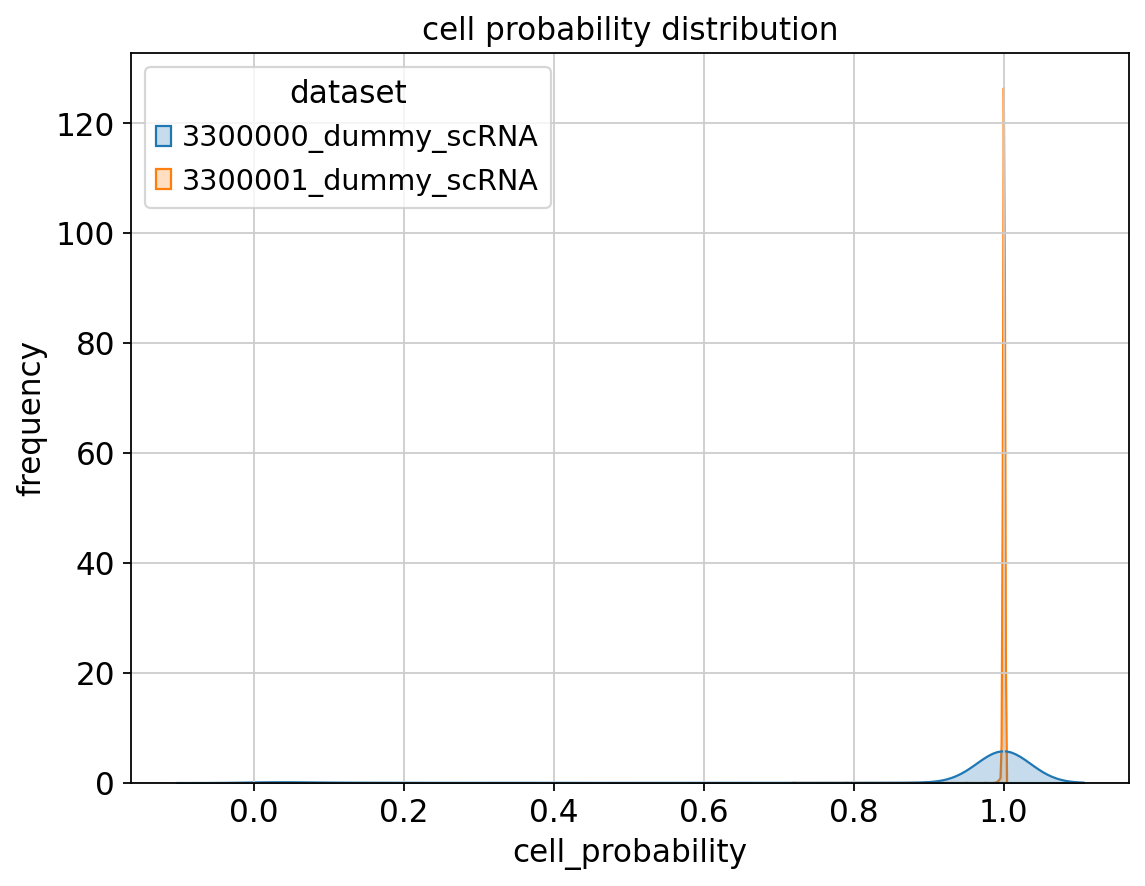

In [23]:
# Create the density plot
plt.figure(figsize=(8, 6))
a = merged_adata.obs[['cell_probability', "batch_names"]]
ax = sns.kdeplot(data = a, x = 'cell_probability',fill=True, color='blue', hue = "batch_names")  # fill=True adds shading under the curve

# Add labels and title
plt.title("cell probability distribution")
plt.xlabel("cell_probability")
plt.ylabel("frequency")

sns.move_legend(ax, "upper left", title='dataset')

# Show the plot
plt.show()

# Filtering out low quality samples based on CellBender metrics

In [24]:
adata = merged_adata[merged_adata.obs['cell_probability']  > 0.9]
adata

View of AnnData object with n_obs × n_vars = 7709 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

# STEP2: Filter count matrices

### QC count matrix

In [26]:
if species == "human":
    mito_str = "MT-"
    ribo_str = ('RPL', 'RPS')
elif species == "mouse":
    mito_str = "mt-"
    ribo_str = ('Rpl', 'Rps')

adata.var['mito']=adata.var_names.str.startswith(mito_str) 
adata.var['ribo']=adata.var_names.str.startswith(ribo_str) 
sc.pp.calculate_qc_metrics(adata, inplace=True, qc_vars = ['mito', 'ribo'], percent_top=None, log1p = False)

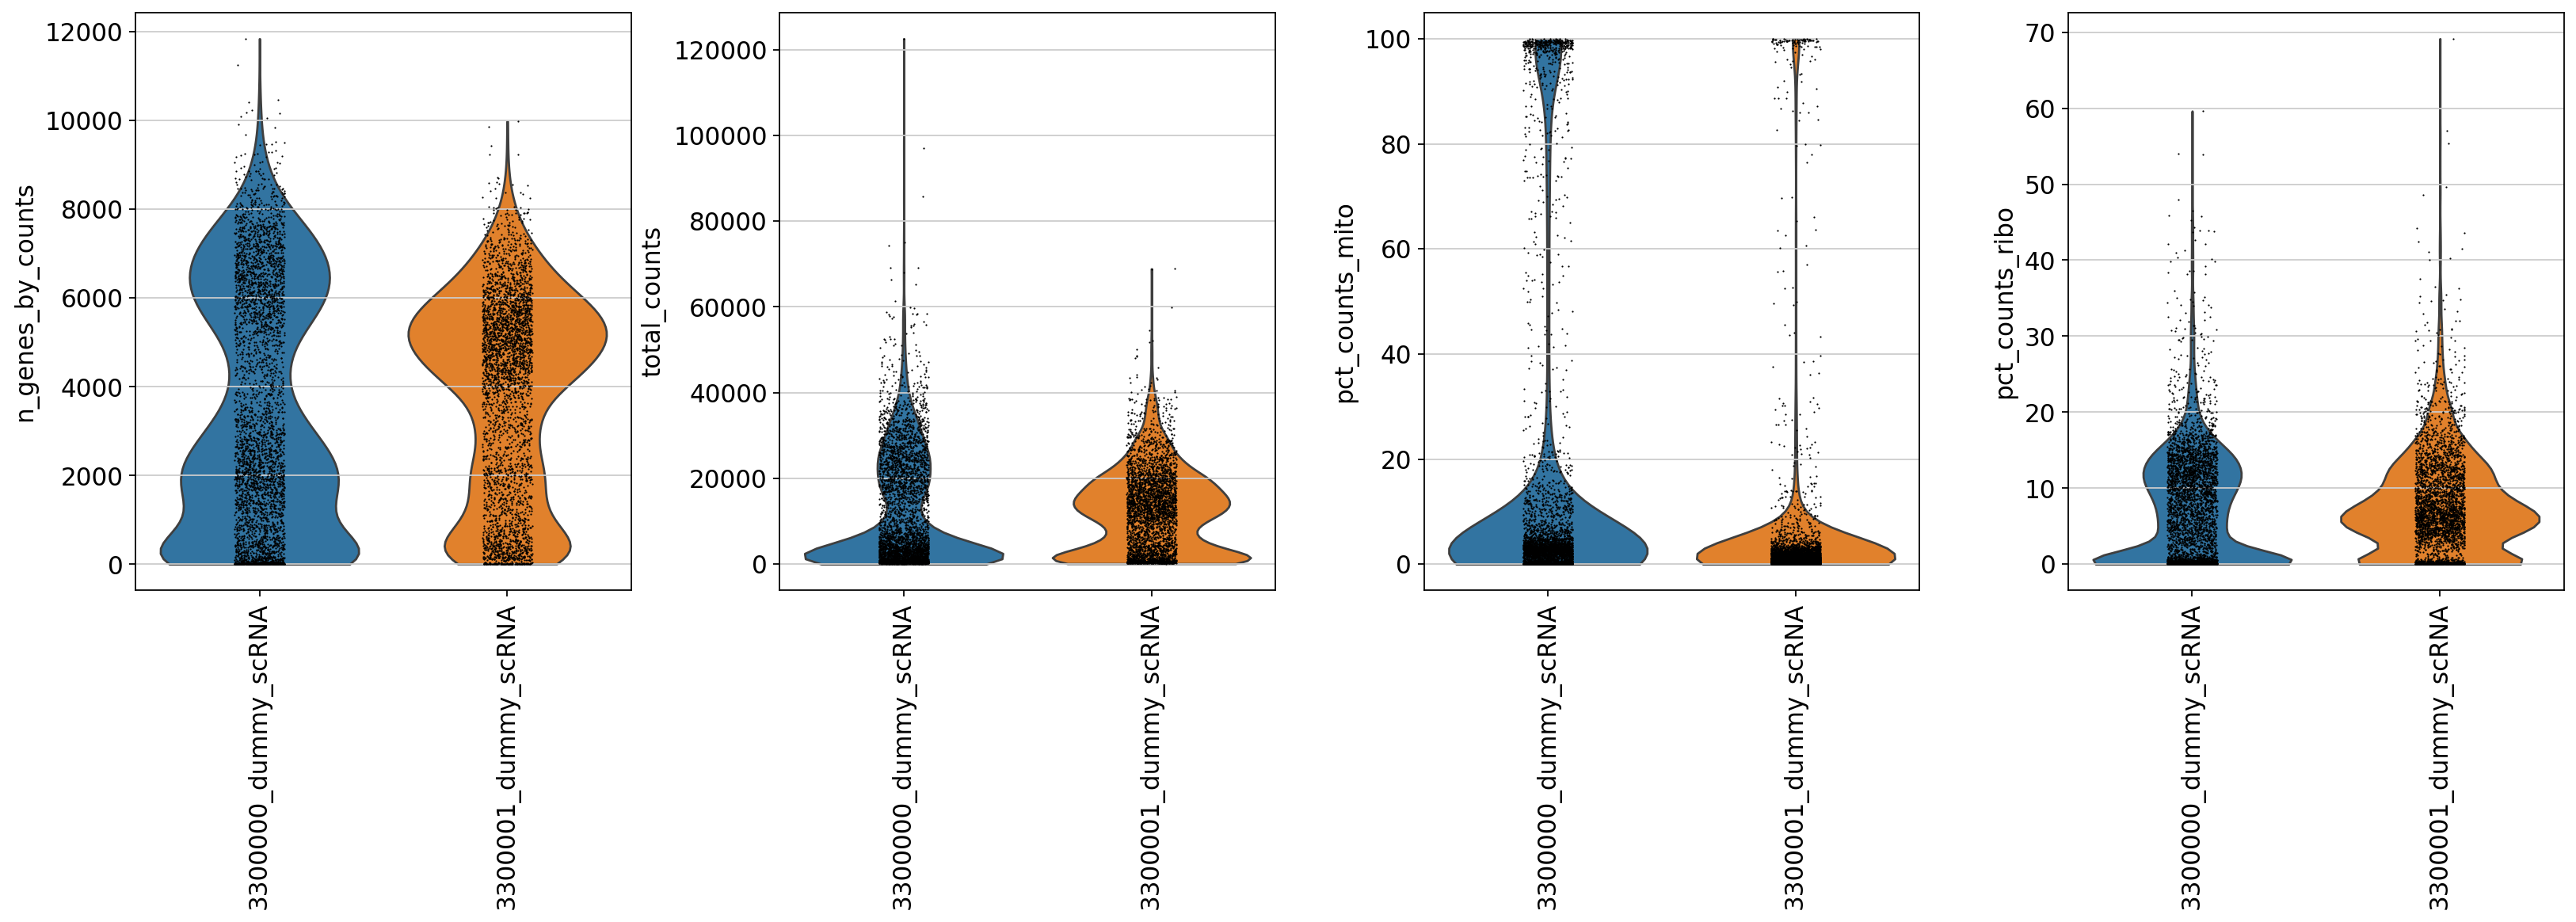

In [27]:
matplotlib.rcParams['figure.figsize'] = [5,6]
sc.pl.violin(adata, groupby="batch_names",keys=["n_genes_by_counts", "total_counts","pct_counts_mito",'pct_counts_ribo'], multi_panel=True, rotation=90)

In [28]:
# these are just suggested thresholds, you can adjust them based on your data
# check the violin plots above to see the distribution of the metrics
if sc_sn == 'sc':
    mito_thresh = 10
elif sc_sn == 'sn':
    mito_thresh = 1
 

In [29]:
nuclei_mito = (adata.obs["pct_counts_mito"] < mito_thresh)

adata_filtered =adata[ nuclei_mito]
adata_filtered

View of AnnData object with n_obs × n_vars = 6525 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_names_colors'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [31]:
adata_filtered.obs['batch_names'].unique()

['3300000_dummy_scRNA', '3300001_dummy_scRNA']
Categories (2, object): ['3300000_dummy_scRNA', '3300001_dummy_scRNA']

In [32]:
np.unique(adata_filtered.obs.batch_names, return_counts = True)

(array(['3300000_dummy_scRNA', '3300001_dummy_scRNA'], dtype=object),
 array([3255, 3270]))

### Filter outlier cells

In [36]:
# package in the same folder as this notebook
import filter_functions.filter as fff

### -- filter based on number of genes

In [37]:
print("Need to run for filtering")

combined_filtered=pd.DataFrame()
obs_meta=adata_filtered.obs.copy()
for batch in tqdm(adata_filtered.obs.batch_names.unique()):
    print(f"\n{batch}")
    obs_meta_batch = obs_meta.loc[obs_meta["batch_names"] == batch,:]
    
    outlier_filter_cts_up = fff.filter_outliers_up(np.array(obs_meta_batch.n_genes_by_counts), up_threshold = 3)
    outlier_df_up = pd.DataFrame(outlier_filter_cts_up, columns=["cts_outlier_up"])
    outlier_df_up.index = obs_meta_batch.index
    # np.unique(outlier_df_up.cts_outlier_up, return_counts=True) # True means keep the cell, not outlier
    
    cts_up_filtered_obs = obs_meta_batch.loc[outlier_filter_cts_up,:]
    outlier_filter_cts_down = fff.filter_outliers_down(np.array(cts_up_filtered_obs.n_genes_by_counts), down_threshold = 1)
    outlier_df_down = pd.DataFrame(outlier_filter_cts_down, columns=["cts_outlier_down"])
    outlier_df_down.index = cts_up_filtered_obs.index
    # np.unique(outlier_df_down.cts_outlier_down, return_counts=True)  # True means keep the cell, not outlier
    
    # merge z-score outlier filter
    outlier_df = outlier_df_up.merge(outlier_df_down, left_index=True, right_index=True, how="left")
    outlier_df.index = outlier_df_up.index
    outlier_df["final_filter"] = outlier_df["cts_outlier_up"] & outlier_df["cts_outlier_down"]
    
    combined_filtered = pd.concat([combined_filtered, outlier_df])

Need to run for filtering


  0%|          | 0/2 [00:00<?, ?it/s]


3300000_dummy_scRNA
Filtering out numbers 3 std up:
 Upper filter: 11841
Filtering out numbers below 1674.24.

3300001_dummy_scRNA
Filtering out numbers 3 std up:
 Upper filter: 9981
Filtering out numbers below 2046.91.


In [38]:
obs_meta_genes=obs_meta.merge(combined_filtered, left_index = True, right_index =True, how="left")
obs_meta_genes["final_filter_2"] = np.where(pd.isna(obs_meta_genes.final_filter), False,obs_meta_genes.final_filter)
# obs_meta_2
np.unique(obs_meta_genes.final_filter_2,return_counts=True)

(array([False,  True]), array([1397, 5128]))

### -- filter based on number of reads

In [39]:
print("Need to run for filtering")

combined_filtered=pd.DataFrame()
obs_meta=adata_filtered.obs.copy()
for batch in tqdm(adata_filtered.obs.batch_names.unique()):
    print(f"\n{batch}")
    obs_meta_batch = obs_meta.loc[obs_meta["batch_names"] == batch,:]
    
    outlier_filter_cts_up = fff.filter_outliers_up(np.array(obs_meta_batch.total_counts), up_threshold = 3)
    outlier_df_up = pd.DataFrame(outlier_filter_cts_up, columns=["cts_outlier_up"])
    outlier_df_up.index = obs_meta_batch.index
    # np.unique(outlier_df_up.cts_outlier_up, return_counts=True) # True means keep the cell, not outlier
    
    cts_up_filtered_obs = obs_meta_batch.loc[outlier_filter_cts_up,:]
    outlier_filter_cts_down = fff.filter_outliers_down(np.array(cts_up_filtered_obs.total_counts), down_threshold = 1, hard_filter=500)
    outlier_df_down = pd.DataFrame(outlier_filter_cts_down, columns=["cts_outlier_down"])
    outlier_df_down.index = cts_up_filtered_obs.index
    # np.unique(outlier_df_down.cts_outlier_down, return_counts=True)  # True means keep the cell, not outlier
    
    # merge z-score outlier filter
    outlier_df = outlier_df_up.merge(outlier_df_down, left_index=True, right_index=True, how="left")
    outlier_df.index = outlier_df_up.index
    outlier_df["final_filter"] = outlier_df["cts_outlier_up"] & outlier_df["cts_outlier_down"]
    
    combined_filtered = pd.concat([combined_filtered, outlier_df])


Need to run for filtering


  0%|          | 0/2 [00:00<?, ?it/s]


3300000_dummy_scRNA
Filtering out numbers 3 std up:
 Upper filter: 55340
Filtering out numbers below 2099.50.

3300001_dummy_scRNA
Filtering out numbers 3 std up:
 Upper filter: 41483
Filtering out numbers below 4093.21.


In [40]:
obs_meta_counts=obs_meta.merge(combined_filtered, left_index = True, right_index =True, how="left")
obs_meta_counts["final_filter_2"] = np.where(pd.isna(obs_meta_counts.final_filter), False,obs_meta_counts.final_filter)
# obs_meta_2
np.unique(obs_meta_counts.final_filter_2,return_counts=True)

(array([False,  True]), array([1329, 5196]))

### -- merge filtered cells from genes and reads filter

In [41]:
adata_filtered =adata_filtered[obs_meta_genes.final_filter_2 & obs_meta_counts.final_filter_2,:]
adata_filtered

View of AnnData object with n_obs × n_vars = 5030 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_names_colors'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

### Filter based on DropletQC metrics

- filter for DropletQC are suggested thresholds, please adjust them based on your data
- scatter plot will be create when running this block
- **no real filtering is done in this block**
- please adjust the thresholds based on your data befor moving to the next block


- `nf_cut`: hard cutoff for nuclear fraction
- `umi_cut`: hard cutoff for umi
- `threshold_nf`: stds for nuclear fraction
- `threshold_umi`: stds for umi

* the function will take the **higher** number from `cut` and `threshold` criteria as the final cutoff.

3300000_dummy_scRNA


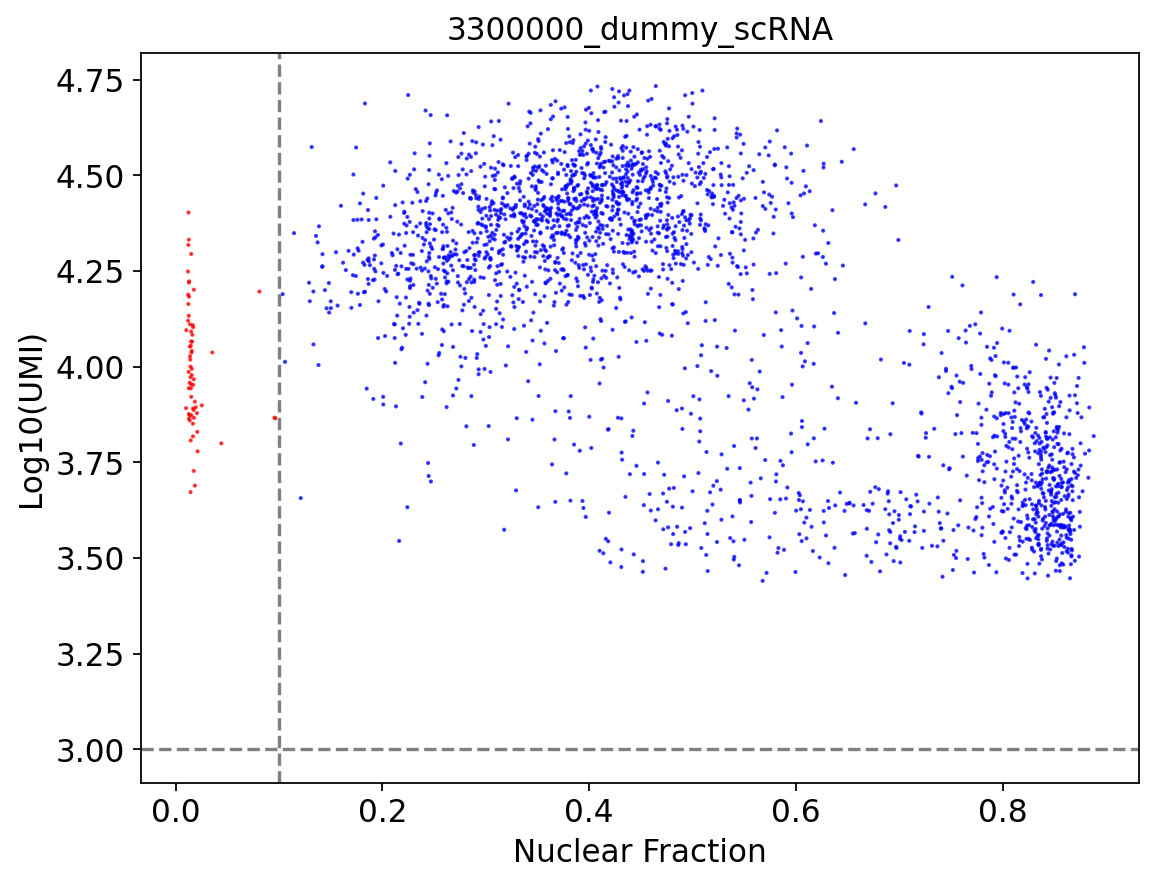

3300001_dummy_scRNA


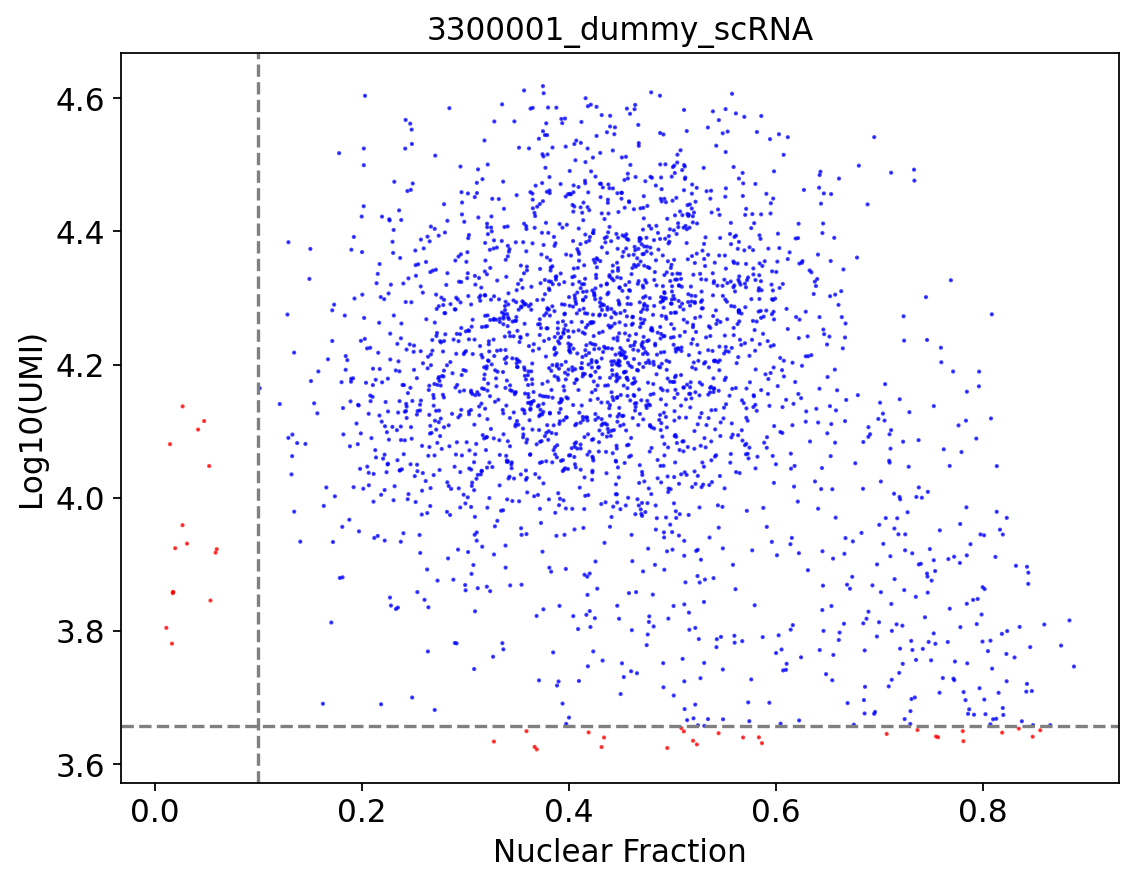

need to run


In [42]:
all_outliers = []
for batch in adata.obs.batch_names.unique():
    if sc_sn == 'sn':
        cur_ol = fff.get_dropletQC_outlier(adata_filtered, batch, threshold_nf=2.5,threshold_umi =2.5, nf_cut=0.6, umi_cut=2.5)
    elif sc_sn == 'sc':
        cur_ol = fff.get_dropletQC_outlier(adata_filtered, batch, threshold_nf =2.5,threshold_umi= 2.5, nf_cut=0.1, umi_cut=3)
    all_outliers = all_outliers + list(cur_ol)
print("need to run")

In [43]:
# number of cells to filter out based on dropletQC
combined_outliers = all_outliers
len(combined_outliers)

107

In [44]:
# filter empty droplets based on dropletQC
adata_filtered = adata_filtered[~adata_filtered.obs_names.isin(combined_outliers),:]
adata_filtered

View of AnnData object with n_obs × n_vars = 4923 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_names_colors'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

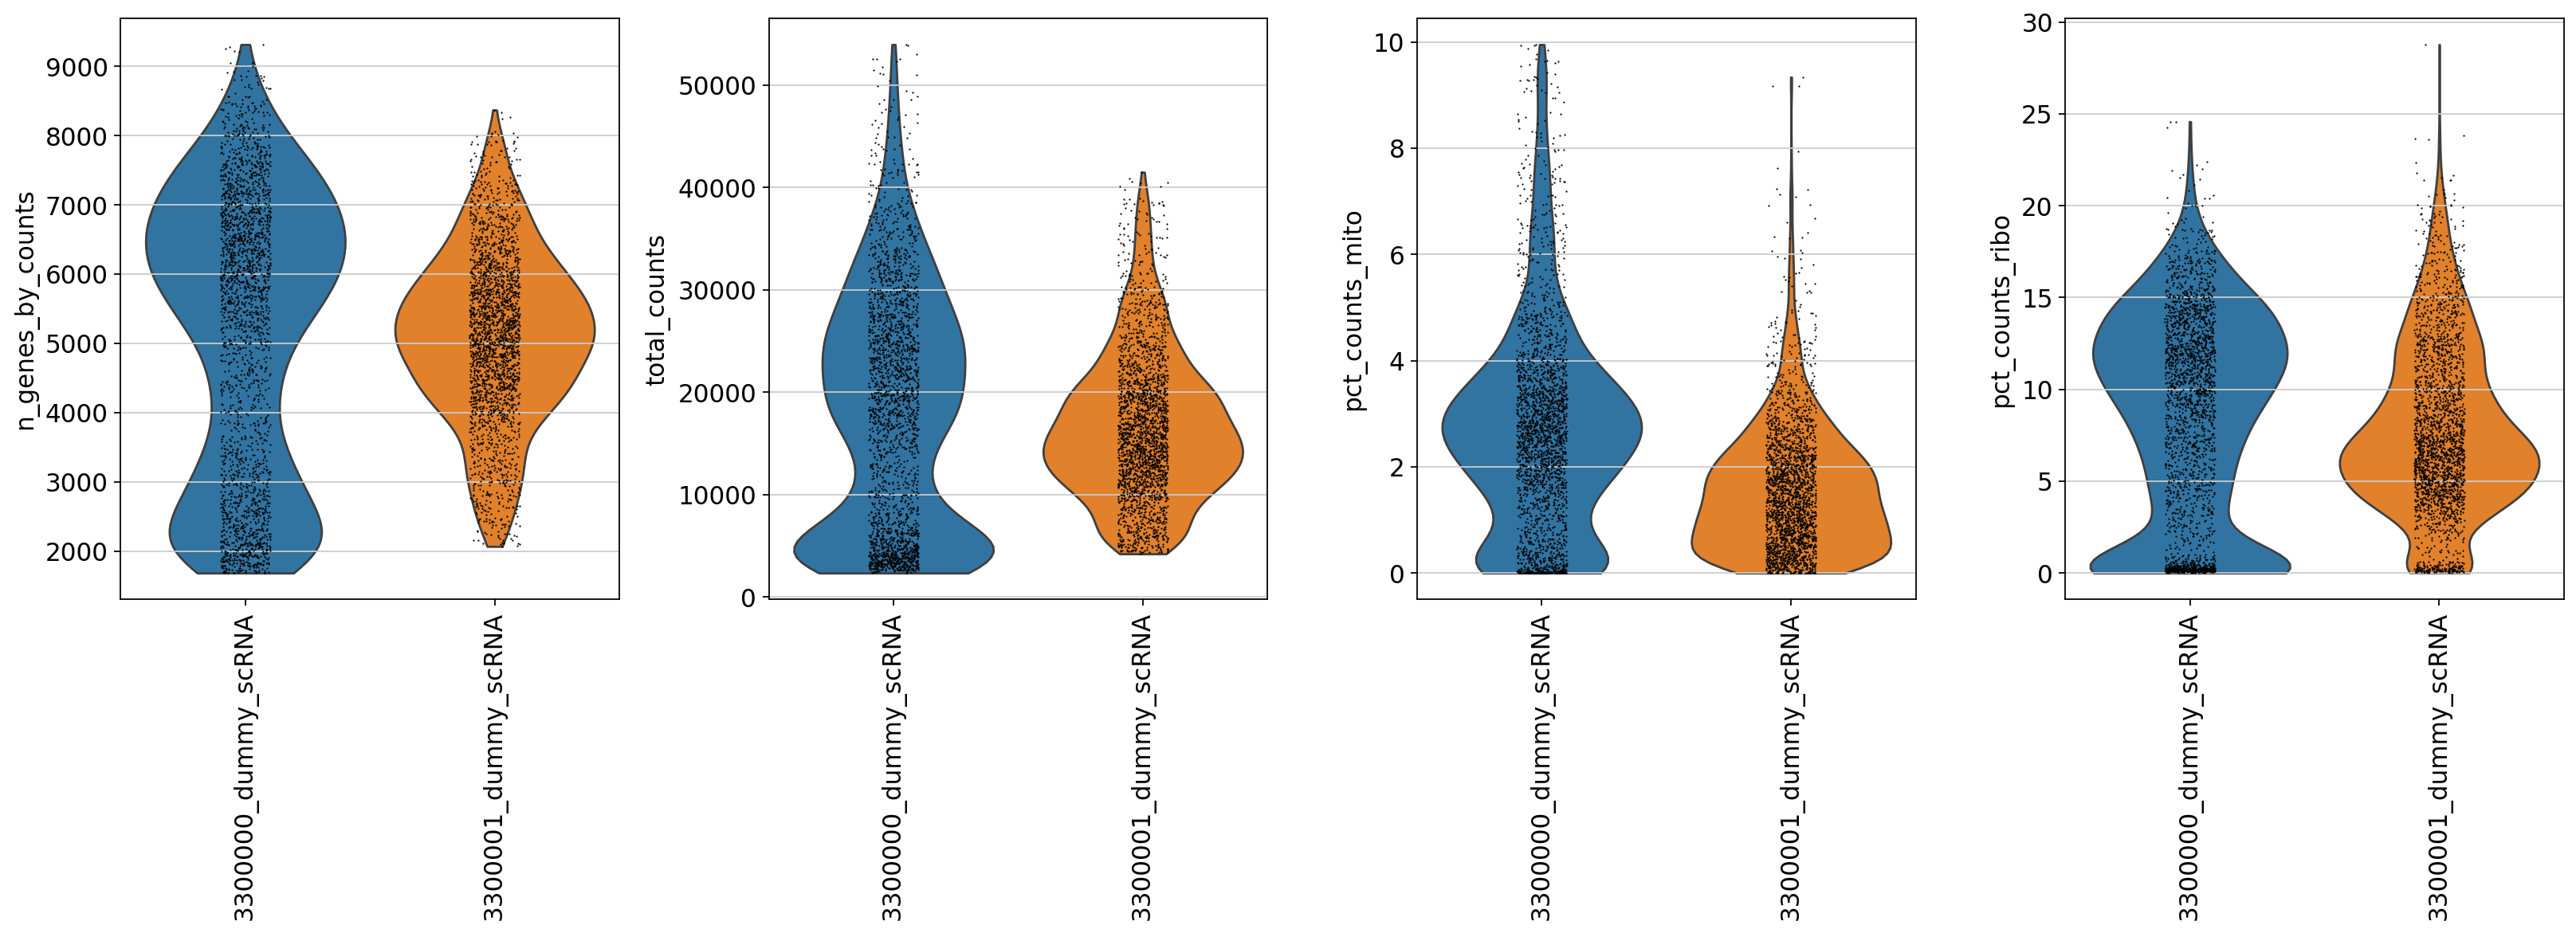

In [45]:
matplotlib.rcParams['figure.figsize'] = [5,6]
sc.pl.violin(adata_filtered, groupby="batch_names",keys=["n_genes_by_counts", "total_counts","pct_counts_mito",'pct_counts_ribo'], multi_panel=True, rotation=90)
    

### Filter doublet

In [46]:
if sc_sn == 'sn':
    adata_filtered.obs['sample_prep'] = 'single-nuclei'
elif sc_sn == 'sc':
    adata_filtered.obs['sample_prep'] = 'single-cell'
    
np.unique(adata_filtered.obs['sample_prep'], return_counts = True)

(array(['single-cell'], dtype=object), array([4923]))

In [48]:
sce.pp.scrublet(adata_filtered, batch_key="batch_names")

In [ ]:
# # USE THIS TO CHECK WHICH SAMPLE CAUSED SCRUBLET TO FAIL.
# all_doublet_stats = pd.DataFrame()
# for batch in tqdm( np.unique(adata_filtered.obs.batch_names)):
#     print(batch)
#     adata_filtered_test = adata_filtered[(adata_filtered.obs["batch_names"] == batch),:] 
#     sce.pp.scrublet(adata_filtered_test, batch_key="batch_names")
#     all_doublet_stats = pd.concat([all_doublet_stats, adata_filtered_test.obs[["doublet_score","predicted_doublet"]]], axis=0)
# all_doublet_stats

In [49]:
adata_filtered.write(output_h5ad+ '_cts_filtered_step1.h5ad')

## Filter genes

- not filter genes to keep essential genes (ex. ATOH1) at very early stage
   

In [50]:
output_h5ad+ '_cts_filtered_step1.h5ad'

'/home/rxu28/software/sc_workflow/Processed/writes/merged_cts_filtered_step1.h5ad'

In [51]:
adata_filtered = sc.read(output_h5ad+ '_cts_filtered_step1.h5ad')
adata_filtered

AnnData object with n_obs × n_vars = 4923 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_names_colors', 'scrublet'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [52]:
min_cells = 1 # adjust this based on your data

sc.pp.filter_genes(adata_filtered, min_cells=min_cells)
adata_filtered

AnnData object with n_obs × n_vars = 4923 × 31975
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_names_colors', 'scrublet'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [53]:
# sc.pl.highest_expr_genes(adata_filtered, n_top=20)

In [54]:
# save count to a layer before normalize and log data
adata_filtered.layers['counts'] = adata_filtered.X.copy()

In [55]:
np.unique(adata_filtered.obs['batch_names'], return_counts = True)
len(np.unique(adata_filtered.obs['batch_names']))

(array(['3300000_dummy_scRNA', '3300001_dummy_scRNA'], dtype=object),
 array([2469, 2454]))

2

##### if you want to filter out samples with low number of genes, please run the following code

In [56]:

# obs_meta = adata_filtered.obs.copy()
# for batch in tqdm( np.unique(adata_filtered.obs.batch_names)):
#     batch_cells = obs_meta[obs_meta["batch_names"] == batch]
#     n_cells = batch_cells.shape[0]
#     if n_cells < 300:
#         print(f"samples {batch} has {n_cells} in the sample. remove for the object.")
#         adata_filtered = adata_filtered[~(adata_filtered.obs.batch_names == batch)]
# adata_filtered


In [57]:
np.unique(adata_filtered.obs['batch_names'], return_counts = True)
len(np.unique(adata_filtered.obs['batch_names']))

(array(['3300000_dummy_scRNA', '3300001_dummy_scRNA'], dtype=object),
 array([2469, 2454]))

2

In [58]:
adata_filtered

AnnData object with n_obs × n_vars = 4923 × 31975
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_names_colors', 'scrublet'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

In [59]:
adata_filtered.write(output_h5ad + "_cts_filtered.h5ad")

### Remove ribosomal and mitochondrial genes and other highly express genes

- please run this step based on your own need

In [60]:
mito_genes = adata_filtered.var_names.str.startswith(mito_str)
ribo_genes = adata_filtered.var_names.str.startswith(ribo_str)

# remove = np.add(mito_genes, malat1)
remove = np.add(mito_genes, ribo_genes)
keep = np.invert(remove)
# keep

In [61]:
adata_filtered = adata_filtered[:,keep]
adata_filtered

View of AnnData object with n_obs × n_vars = 4923 × 31857
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_names_colors', 'scrublet'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

In [62]:
adata_filtered
output_h5ad + "_cts_filtered_noRiboMito.h5ad"

View of AnnData object with n_obs × n_vars = 4923 × 31857
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_names_colors', 'scrublet'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

'/home/rxu28/software/sc_workflow/Processed/writes/merged_cts_filtered_noRiboMito.h5ad'

In [63]:
adata_filtered.write(output_h5ad + "_cts_filtered_noRiboMito.h5ad")

# Run Scanpy workflow

- submit the following code to run the Scanpy workflow 
- please adjust the parameters based on your data
- this workflow will run the following steps:
    - normalization + log transformation
    - scoreing CC
    - select HVGs
    - scaling + regressing out unwanted sources of variation
    - PCA
    - integration if `batch` is provided
    - UMAP
    - clustering

*NOTE, if `batch_for_highvar` is provided, the HVGs will be selected per batch, final HVGs will selected by:

$$
\text{n\_hvgs} = \sum_{k=1}^{n} g_k
$$

Where:

- $n$: total number of batches  
- $g_k$: number of genes that exist in exactly $k$ batches  
- **n_hvgs**: total number of high-variable genes across all batches  


In [ ]:
%%writefile scanpy_basic_workflow_sn_sc_combined.py
import os
import scanpy as sc
import scanpy.external as sce
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from scipy.sparse import isspmatrix_csr

workdir="/home/rxu28/software/sc_workflow/Processed"

input_h5ad =f"/home/rxu28/software/sc_workflow/Processed/writes/merged" + "_cts_filtered_noRiboMito.h5ad"
output_h5ad = os.path.join(os.path.dirname(input_h5ad), os.path.basename(input_h5ad).split("_cts_filtered_noRiboMito.h5ad")[0]) 

add = '' # if additional filename need to be added, add here
output_h5ad = output_h5ad  + add

cell_cycle_fn = "/research/groups/northcgrp/home/common/Rachel/data/genesets/regev_lab_cell_cycle_genes.txt"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
figure_path = os.path.join(workdir, "Scripts", 'figures', f"figures-{timestamp}")
print(f"# Creating figure folder: {figure_path}")
os.makedirs(figure_path, exist_ok=True)

print(f'Reading in: {input_h5ad}')
print(f'Output: {output_h5ad}_processed.h5ad')
adata = sc.read(input_h5ad)
batch_for_highvar =  None 
batch =['batch_names']
variables = ['total_counts','pct_counts_mito','CC_Difference'] # keys to regress out
method = "harmony"
n_jobs = 6

scale_mtx = True
pcs = 50 # this need to change based on scree plot
n_neighbors = 50
use_tsne = False
use_umap = True
resolution = 1
n_hvgs= 3000


print("WORKFLOW starts:")
adata.layers["counts"] = adata.X.copy()

print("1) Normalize and log transform data")
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True, exclude_highly_expressed = True)
# log1p transform
sc.pp.log1p(adata)

print("2) Save log transformed data to a layer")
adata.layers["log1p_norm"] = adata.X.copy()

print("3) Score genesets")
# get cell cycle genes (can be obtained using cc.genes in seurat package)
cell_cycle_genes = [x.strip() for x in open(cell_cycle_fn)]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.uns = {}

print("4) Identifying highly variable genes. Identify HVGs in different batches.")

if (batch_for_highvar is not None) and (len(adata.obs[batch_for_highvar].unique()) > 1):
    print("5.1) if len(batch_for_highva) > 1. get HVG counts for each batch")
    from upsetplot import UpSet
    # Dictionary to store HVGs from each dataset
    hvg_ls = {}
    for dataset in adata.obs[batch_for_highvar].unique():  # dynamically get dataset names
        print(dataset)
        ad_subset = adata[adata.obs[batch_for_highvar] == dataset]
        sc.pp.highly_variable_genes(ad_subset, min_mean=0.0125, min_disp=0.5, max_mean=3)
        print("Highly variable genes for {}: {}".format(dataset, sum(ad_subset.var.highly_variable)))
        hvg_ls[dataset] = set(ad_subset.var[ad_subset.var.highly_variable].index)
    # Combine all unique elements from all datasets
    all_elements = set.union(*hvg_ls.values())
    # Create a DataFrame with membership information for each dataset
    membership_dict = {'Element': list(all_elements)}
    for dataset, genes in hvg_ls.items():
        membership_dict[dataset] = [1 if elem in genes else 0 for elem in all_elements]
    df = pd.DataFrame(membership_dict)
    # Count occurrences of each unique combination of set memberships
    upset_data = df.groupby(list(hvg_ls.keys())).size()
    # Plotting the UpSet plot
    UpSet(upset_data).plot()
    plt.title("Intersections of HVGs across datasets")
    plt.savefig(os.path.join(figure_path, 'HVGs_intersection.png'))

def select_hvg_genes(df, target_count=5000):
    chosen_genes = pd.Series(False, index=df.index)  # Boolean column to indicate chosen genes
    current_count = 0  # Track how many genes have been chosen
    max_batches = df['highly_variable_nbatches'].max()
    for i in range(max_batches, 0, -1):
        subset = df[(df['highly_variable_nbatches'] == i) & (~chosen_genes)]
        subset = subset.sort_values(by='dispersions_norm', ascending=False)
        remaining_needed = target_count - current_count
        chosen_in_this_step = subset.head(remaining_needed).index
        chosen_genes[chosen_in_this_step] = True
        current_count += len(chosen_in_this_step)
        if current_count >= target_count:
            break
    df['highly_variable_chosen'] = chosen_genes
    return df

if batch_for_highvar != None:
    sc.pp.highly_variable_genes(adata,min_mean=0.0125, min_disp=0.5, max_mean = 3, batch_key = batch_for_highvar )
    hvg_var_df = select_hvg_genes(adata.var.copy(), target_count=n_hvgs)
    adata.var = hvg_var_df.copy()
    var_select = adata.var.highly_variable_chosen
else:
    sc.pp.highly_variable_genes(adata,n_top_genes=n_hvgs)
    var_select = adata.var.highly_variable

adata.write(output_h5ad+ "_norm.h5ad")

print("5) Save log normalized matrix as raw.")
adata.raw = adata

adata = adata[:,var_select]
keep_n = adata.shape[1]
print(f'select {keep_n} HVGs from all datasets')

print("6) scale matrix")
adata.obs['CC_Difference'] = adata.obs['S_score'] - adata.obs['G2M_score'] 
var_str = ",".join(variables)

print(f"    - regressing out variables before scaling: {var_str}")
sc.pp.regress_out(adata, keys= variables, n_jobs=n_jobs)

if scale_mtx:
    print('Scaling Mtx')
    sc.pp.scale(adata, max_value=10)

print("7) Dimension reduction")
print(f"*Using {method} for integration.")

print(f"    - using {pcs} for dimension reduction.")
sc.tl.pca(adata, n_comps=pcs, svd_solver='arpack')
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.pca_scatter(adata, show=False)
    plt.savefig(os.path.join(figure_path, "pca_scatter.png"), bbox_inches="tight")

with plt.rc_context():
    sc.pl.pca_variance_ratio(adata, log=False, show=False, n_pcs = pcs)
    plt.savefig(os.path.join(figure_path, "pca_variance_scree.png"), bbox_inches="tight")

if use_tsne:
    print("    - Plotting T-SNE")
    sc.tl.tsne(adata, n_pcs=pcs, n_jobs=n_jobs)
    ax = sc.pl.tsne(adata, save='.png', show=False)

if use_umap:
    print("    - Plotting UMAP")
    if batch is None:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric="cosine")
    else:
        print("      - Batch correcting")
        #sce.pp.bbknn(adata, batch, n_pcs=pcs)
        if method == "harmony":
            sce.pp.harmony_integrate(adata, batch, max_iter_harmony=50)
            sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric="cosine", use_rep="X_pca_harmony")
        elif method == "scanorama":
            sce.pp.scanorama_integrate(adata, batch[0])
            sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric="cosine", use_rep="X_scanorama")
    
    sc.tl.umap(adata, min_dist=0.1, spread=2)
    
    with plt.rc_context():  # Remove rc_context if no specific settings are needed
        if batch is None:
            sc.pl.umap(adata, show=False)
        else:
            sc.pl.umap(adata, color=batch, show=False)
        plt.savefig(os.path.join(figure_path, "umap.png"), bbox_inches="tight")

print("8) Clustering cells using leiden algorithm with %f resolution"%(resolution))
sc.tl.leiden(adata, resolution=resolution)

adata.write(output_h5ad+ "_processed.h5ad")

print("9) Find markers")
sc.tl.rank_genes_groups(adata, key_added="wilcoxon", method="wilcoxon", pts=True, groupby="leiden", tie_correct=True)


adata.write(output_h5ad+ "_processed.h5ad")


Overwriting scanpy_basic_workflow_sn_sc_combined.py


In [ ]:
! bsub -q priority -P all_steps_scanpy -R "rusage[mem=50GB]" -R "span[hosts=1]" -n 1 -o "all_steps_scanpy_sn_sc_combined.%J.out" -e "all_steps_scanpy_sn_sc_combined.%J.out" "python scanpy_basic_workflow_sn_sc_combined.py"

Job <260153660> is submitted to queue <priority>.


# Explore UMAP

In [ ]:
output_h5ad = '/home/rxu28/software/sc_workflow/Processed/writes/merged'

In [287]:
output_h5ad + "_processed.h5ad"

'/research/groups/northcgrp/home/common/Rachel/organoid/Benchmark/single-cell/Data/writes/Benchmark_EB_processed.h5ad'

In [ ]:
adata_highvar = sc.read(output_h5ad + "_processed.h5ad")
adata_highvar

AnnData object with n_obs × n_vars = 30692 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'sample', 'Timepoint', 'Protocol', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'nf_umi_ratio', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', 'EGL', 'RLvz', 'RLsvz', 'PCL', 'Granule cell', 'Unipolar Brush Cell', 'Oligodendrocytes', 'Microglia', 'Astrocytes', 'Purkinje Cell', 'Photoreceptor Cell', 'Limbic System', 'Vascular_Endo', 'CC_Difference', 'leiden'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_names_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'w

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'scaled')

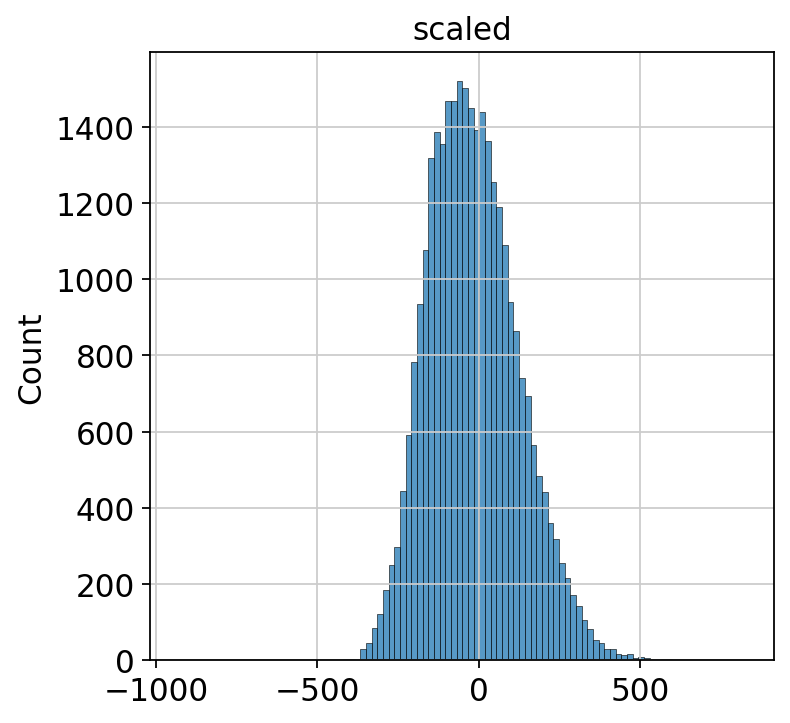

In [289]:
%matplotlib inline
fig, axes = plt.subplots(1,1,figsize=(5,5))
sns.histplot(adata_highvar.X.sum(1), bins = 100, kde=False, ax = axes)
axes.set_title("scaled")

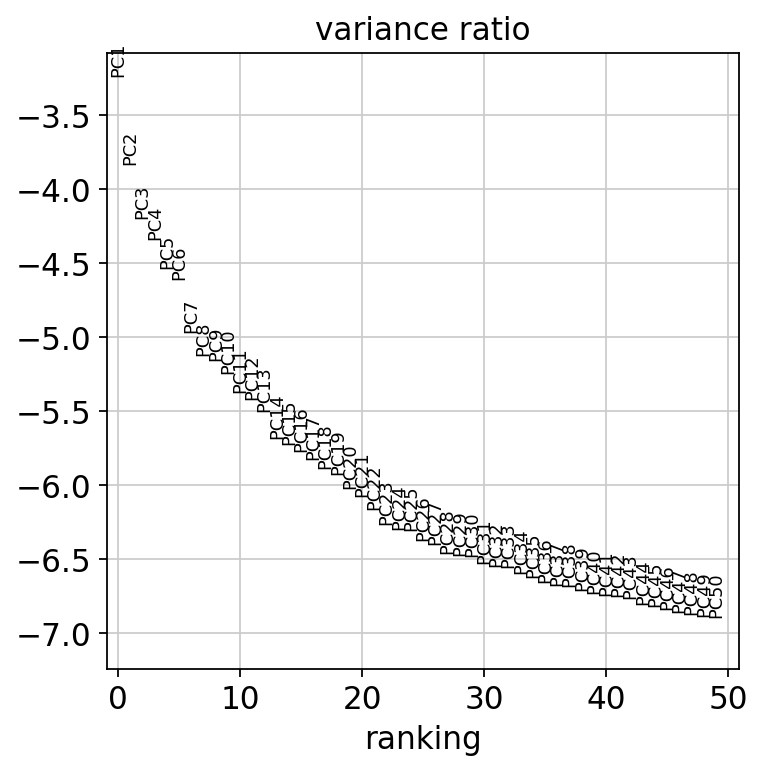

In [290]:
matplotlib.rcParams["figure.figsize"]= [5,5]
sc.pl.pca_variance_ratio(adata_highvar, log=True,  n_pcs = len(adata_highvar.varm['PCs'][0]))

## explore UMAP

In [337]:
matplotlib.rcParams['figure.figsize'] = [6,6]
import ipywidgets as widgets
from IPython.display import display

def plot_umap(color_by):
    # sc.pl.scatter(adata_highvar, basis = 'diffmap_pca', color=[color_by])
    sc.pl.umap(adata_highvar, color=[color_by],na_color ='white')  # add "palette = celltype_colors_generalized,", if try to see Lu_celltype2 or Kaess_celltype2, , legend_loc = "on data"

dropdown=widgets.Dropdown(
    options=adata_highvar.obs.columns,
    value=adata_highvar.obs.columns[8],
    description="Observation: "
)
matplotlib.rcParams["figure.figsize"] = [5,5]
widgets.interactive(plot_umap, color_by=dropdown)

interactive(children=(Dropdown(description='Observation: ', index=8, options=('background_fraction', 'cell_pro…

# combine processed with counts

In [319]:
adata_norm = sc.read(output_h5ad + '_norm.h5ad')
adata_norm

AnnData object with n_obs × n_vars = 30692 × 38486
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'sample', 'Timepoint', 'Protocol', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'nf_umi_ratio', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', 'EGL', 'RLvz', 'RLsvz', 'PCL', 'Granule cell', 'Unipolar Brush Cell', 'Oligodendrocytes', 'Microglia', 'Astrocytes', 'Purkinje Cell', 'Photoreceptor Cell', 'Limbic System', 'Vascular_Endo'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'gene_expression_encoding'
    layers: 'ambiguous', 'counts', 'log1p_norm', 'matrix', 'spliced

In [320]:
ad_comb = sc.AnnData(adata_norm.layers['counts'], obs = adata_highvar.obs, var = adata_norm.var, uns = adata_highvar.uns, obsm = adata_highvar.obsm, layers = adata_norm.layers, obsp = adata_highvar.obsp)
ad_comb

AnnData object with n_obs × n_vars = 30692 × 38486
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'nf', 'umi', 'cell_status', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch_names', 'sample', 'Timepoint', 'Protocol', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'nf_umi_ratio', 'sample_prep', 'n_genes', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', 'EGL', 'RLvz', 'RLsvz', 'PCL', 'Granule cell', 'Unipolar Brush Cell', 'Oligodendrocytes', 'Microglia', 'Astrocytes', 'Purkinje Cell', 'Photoreceptor Cell', 'Limbic System', 'Vascular_Endo', 'CC_Difference', 'leiden'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_names_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'wilcoxon', 'Pro

In [321]:
output_h5ad + '_processed_cts.h5ad'

'/research/groups/northcgrp/home/common/Rachel/organoid/Benchmark/single-cell/Data/writes/Benchmark_EB_processed_cts.h5ad'

In [322]:
ad_comb.write(output_h5ad + '_processed_cts.h5ad')